In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
from torch.autograd import Variable
import numpy as np

import time
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

class scmf(nn.Module):
    def __init__(self,
                 X_train, y_train,
                 hidden_size=4,
                 output_size=1,
                 device='cuda'):
        super(scmf, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device =='cpu':
            self.device = torch.device('cpu')

        self.X_train = X_train.to(self.device)
        self.y_train = y_train.to(self.device) # binary label. Need to revise for multi-class using one-hot encoding.
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.model_Classification = self._initialize_classification_model().to(self.device)
        self.model_MF = self._initialize_matrix_factorization_model().to(self.device)
        self.model_Classification_beta = self._initialize_classification_model_for_beta().to(self.device)
        self.model_MF_H = self._initialize_matrix_factorization_model_for_H().to(self.device)

        self.result_dict = {}
        self.result_dict.update({'n_components' : hidden_size})
        self.result_dict.update({'Training_threshold': 0.5})

    def _initialize_classification_model(self):
        class Classification(nn.Module):
            def __init__(self, input_size, hidden_size, output_size=1):
                super(Classification, self).__init__()
                self.linear_W = nn.Linear(input_size, hidden_size, bias = False) # W.T @ X
                self.linear_beta = nn.Linear(hidden_size, output_size) # activation beta.T @ (W.T @ X)
                
            def forward(self, x):
                x1 = self.linear_W(x)
                x2 = self.linear_beta(x1)
                x3 = torch.sigmoid(x2)
                return x3

        model = Classification(self.X_train.shape[1], self.hidden_size, self.output_size)
        return model.to(self.device)

    def _initialize_matrix_factorization_model(self):
        class MF(nn.Module):
            def __init__(self, X, hidden_size):
                super(MF, self).__init__()
                self.W = nn.Parameter(torch.rand(X.shape[0], hidden_size).clamp(min=1e-8))
                self.H = nn.Parameter(torch.rand(hidden_size, X.shape[1]).clamp(min=1e-8))
                
            def forward(self):
                return torch.mm(self.W, self.H)

        model = MF(self.X_train.T, self.hidden_size)
        return model

    def _initialize_classification_model_for_beta(self):
        class Classification_beta(nn.Module):
            def __init__(self, hidden_size, output_size=1):
                super().__init__()
                self.linear_beta = nn.Linear(hidden_size, output_size)

            def forward(self, a):
                act = self.linear_beta(a) # input a = W.T @ X
                y_pred = torch.sigmoid(act)
                return y_pred

        model = Classification_beta(self.hidden_size, self.output_size)
        return model.to(self.device)

    def _initialize_matrix_factorization_model_for_H(self):
        class MF_H(nn.Module):
            def __init__(self, X, hidden_size):
                super(MF_H, self).__init__()
                self.H = nn.Parameter(torch.rand(hidden_size, X.shape[1]).clamp(min=1e-8))

            def forward(self, W):
                return torch.mm(W, self.H)

        model = MF_H(self.X_train.T, self.hidden_size)
        return model

    def rank_r_projection(self, X, rank):
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components=rank, n_iter=7, random_state=42)
        X_reduced = svd.fit_transform(X.cpu())
        u = X_reduced.dot(np.linalg.inv(np.diag(svd.singular_values_)))
        s = svd.singular_values_
        vh = svd.components_
        r = rank
        u0 = u[:,:r]
        s0 = s[:r]
        v0 = vh[:r,:]
        recons = u0 @ np.diag(s0) @ v0
        return u0, s0, v0, recons

    def fit(self, num_epochs=1000,
            lr_classification=0.1,
            lr_matrix_factorization=0.1,
            xi=1,
            ini_loading=None,
            ini_code=None,
            initialize='spectral',
            W_nonnegativity=True,
            H_nonnegativity=True,
            test_data=None, #or [X_test, y_test]
            record_recons_error=False):

        self.result_dict.update({'xi' : xi})
        self.result_dict.update({'nonnegativity' : [W_nonnegativity, H_nonnegativity]})
        self.result_dict.update({'iter': num_epochs})

        time_error = np.zeros(shape=[3, 0])
        elapsed_time = 0
        self.result_dict.update({"time_error": time_error})

        if ini_loading is not None:
            W0 = Variable(ini_loading[0]).to(self.device)
            Beta0 = Variable(ini_loading[1][:,1:]).to(self.device)
            Beta_bias = Variable(ini_loading[1][:,0]).to(self.device)

            self.model_MF.W = nn.Parameter(W0)
            self.model_Classification.linear_W.weight = nn.Parameter(W0.T)
            self.model_Classification.linear_beta.weight = nn.Parameter(Beta0)
            self.model_Classification.linear_beta.bias = nn.Parameter(Beta_bias)

        if ini_code is not None:
            H0 = Variable(ini_code).to(self.device)
            self.model_MF.H = nn.Parameter(H0)

        if  initialize == 'spectral':
            U0, S0, H0, recons = self.rank_r_projection(self.X_train.T, self.hidden_size)
            W0 = U0 #@ np.diag(S0)

            W0 = Variable(torch.from_numpy(W0)).float().to(self.device)
            H0 = Variable(torch.from_numpy(np.diag(S0) @ H0)).float().to(self.device)

            if ini_loading is None:
                self.model_MF.W = nn.Parameter(W0)
                self.model_Classification.linear_W.weight = nn.Parameter(W0.T)
            if ini_code is None:
                self.model_MF.H = nn.Parameter(H0)

        elif initialize == 'random':
            if ini_loading is None:
                W0 = torch.rand(self.X_train.shape[1], self.hidden_size).to(self.device)
                self.model_MF.W = nn.Parameter(W0)
                self.model_Classification.linear_W.weight = nn.Parameter(W0.T)
            if ini_code is None:
                self.model_MF.H = nn.Parameter(torch.rand(self.hidden_size, self.X_train.shape[0]).to(self.device))

        criterion_Classification = nn.CrossEntropyLoss()
        criterion_MF = nn.MSELoss()

        optimizer_Classification = optim.Adagrad(self.model_Classification.parameters(), lr=lr_classification, weight_decay=0.1)
        optimizer_MF = optim.Adagrad(self.model_MF.parameters(), lr=lr_matrix_factorization, weight_decay=0)

        if record_recons_error:
            self.result_dict.update({'curren_epoch': -1})
            self.result_dict.update({'elapsed_time': 0})

            W_dict = np.asarray(self.model_MF.W.data.cpu().numpy()).copy()
            H = np.asarray(self.model_MF.H.data.cpu().numpy()).copy()
            Beta = np.asarray(self.model_Classification.linear_beta.weight.detach().cpu().numpy()).copy()
            Beta_bias = np.asarray(self.model_Classification.linear_beta.bias.detach().cpu().numpy()).copy()
            Beta_combined = np.hstack((Beta_bias.reshape(self.output_size, -1),Beta))

            self.result_dict.update({'loading': [W_dict, Beta_combined]})
            self.result_dict.update({'code': H})
            self.compute_recons_error()

        for epoch in range(num_epochs):
            self.result_dict.update({'curren_epoch': epoch})
            start = time.time()

            # Update W
            optimizer_Classification.zero_grad()
            y_hat = self.model_Classification(self.X_train)
            loss_Classification = criterion_Classification(y_hat.squeeze(), self.y_train.float())
            loss_Classification.backward()
            optimizer_Classification.step()

            optimizer_MF.zero_grad()
            X_hat = self.model_MF().to(self.device)
            loss_MF = criterion_MF(X_hat, self.X_train.T)
            loss_MF.backward()
            optimizer_MF.step()

            common_W = (xi/(1+xi)) * self.model_MF.W.data.to(self.device) + (1/(1+xi)) * self.model_Classification.linear_W.weight.T
            common_W = common_W/ common_W.norm()
            common_W = common_W.to(self.device)

            if W_nonnegativity:
                common_W = common_W.clamp(min=1e-8)

            with torch.no_grad():
                self.model_Classification.linear_W.weight = nn.Parameter(common_W.T.clone())
 
            with torch.no_grad():
                self.model_MF.W = nn.Parameter(common_W.clone())

            X0 = np.asarray(self.X_train.T.detach().cpu().numpy())
            y_train_cpu = np.asarray(self.y_train.detach().cpu().numpy())
            y_train_cpu = y_train_cpu[np.newaxis,:]
            W0 = np.asarray(self.model_MF.W.data.detach().cpu().numpy())

            # fitting logistic regression again with updated W
            X0_comp = W0.T @ X0
            clf = LogisticRegression(random_state=0).fit(X0_comp.T, y_train_cpu[0])
            beta_weight = torch.from_numpy(clf.coef_).float().to(self.device)
            beta_bias = torch.from_numpy(clf.intercept_).float().to(self.device)

            """
            # torch version
            criterion_Classification_beta = nn.CrossEntropyLoss()
            optimizer_Classification_beta = optim.Adam(self.model_Classification_beta.parameters(), lr=0.1, weight_decay=0.1)
            common_W = torch.from_numpy(W).float().to(self.device)
            a1 = torch.mm(common_W.T, self.X_train.T).T
            for epoch1 in range(10):
                optimizer_Classification_beta.zero_grad()
                y_hat1 = self.model_Classification_beta(a1)
                loss_Classification_beta = criterion_Classification_beta(y_hat1.squeeze(), self.y_train.float())
                loss_Classification_beta.backward(retain_graph=True)
                optimizer_Classification_beta.step()
            """

            # find H with updated W
            criterion_MF_H = nn.MSELoss()
            optimizer_MF_H = optim.Adagrad(self.model_MF_H.parameters(), lr=1)
            for epoch1 in range(5):
                optimizer_MF_H.zero_grad()
                X_hat1 = self.model_MF_H(common_W)
                loss_MF_H = criterion_MF_H(X_hat1, self.X_train.T)
                loss_MF_H.backward(retain_graph=True)
                optimizer_MF_H.step()

                if H_nonnegativity:
                    self.model_MF.H.data = self.model_MF.H.data.clamp(min=1e-8)

            with torch.no_grad():
                self.model_Classification.linear_beta.weight = nn.Parameter(beta_weight.clone())
                self.model_Classification.linear_beta.bias = nn.Parameter(beta_bias.clone())

            with torch.no_grad():
                self.model_MF.H = nn.Parameter(self.model_MF_H.H.data.clone())

            end = time.time()
            elapsed_time += end - start
            self.result_dict.update({'elapsed_time': elapsed_time})

            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}],'
                      f'Loss_Classification: {loss_Classification.item():.4f}',
                      f'Loss_MF: {loss_MF.item():.4f}')

                if test_data is not None:
                    self.test(test_data[0], test_data[1])

                if record_recons_error:
                    loading = {}
                    W_dict = np.asarray(self.model_MF.W.data.cpu().numpy()).copy()
                    H = np.asarray(self.model_MF.H.data.cpu().numpy()).copy()
                    Beta = np.asarray(self.model_Classification.linear_beta.weight.detach().cpu().numpy()).copy()
                    Beta_bias = np.asarray(self.model_Classification.linear_beta.bias.detach().cpu().numpy()).copy()
                    Beta_combined = np.hstack((Beta_bias.reshape(self.output_size, -1),Beta))

                    self.result_dict.update({'loading': [W_dict, Beta_combined]})
                    self.result_dict.update({'code': H})
                    self.compute_recons_error()
        
        loading = {}
        W_dict = np.asarray(self.model_MF.W.data.cpu().numpy()).copy()
        H = np.asarray(self.model_MF.H.data.cpu().numpy()).copy()
        Beta = np.asarray(self.model_Classification.linear_beta.weight.detach().cpu().numpy()).copy()
        Beta_bias = np.asarray(self.model_Classification.linear_beta.bias.detach().cpu().numpy()).copy()
        Beta_combined = np.hstack((Beta_bias.reshape(self.output_size, -1),Beta))

        self.result_dict.update({'loading': [W_dict, Beta_combined]})
        self.result_dict.update({'code': H})
        return self.result_dict

    def compute_recons_error(self):
        
        # print the error every 50 iterations
        W = self.result_dict.get('loading')
        H = self.result_dict.get('code')
        X_train = np.asarray(self.X_train.cpu().numpy()).copy().T
        y_train = np.asarray(self.y_train.cpu().numpy()).copy()
        y_train = y_train.reshape(self.output_size, -1)
        X = [X_train, y_train]

        error_data = np.linalg.norm((X[0] - W[0] @ H).reshape(-1, 1), ord=2)**2
        rel_error_data = error_data / np.linalg.norm(X[0].reshape(-1, 1), ord=2)**2

        X0_comp = W[0].T @ X[0]
        X0_ext = np.vstack((np.ones(X[1].shape[1]), X0_comp))

        P_pred = np.matmul(W[1], X0_ext)
        P_pred = 1 / (np.exp(-P_pred) + 1)
        P_pred = self.model_Classification.forward(self.X_train.to(self.device))
        P_pred = np.asarray(P_pred.detach().cpu().numpy()).T

        fpr, tpr, thresholds = metrics.roc_curve(X[1][0, :], P_pred[0,:], pos_label=None)

        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc = metrics.auc(fpr, tpr)

        Y_hat = P_pred.copy()
        Y_hat[Y_hat < mythre] = 0
        Y_hat[Y_hat >= mythre] = 1
        P_pred = P_pred[0,:]
        Y_hat = Y_hat[0,:]

        self.result_dict.update({'Training_threshold':mythre})
        self.result_dict.update({'Training_AUC':myauc})
        print('--- Training --- [threshold, AUC] = ', [np.round(mythre,3), np.round(myauc,3)])

        mcm = confusion_matrix(y_train[0], Y_hat)
        tn = mcm[0, 0]
        tp = mcm[1, 1]
        fn = mcm[1, 0]
        fp = mcm[0, 1]

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification = 1 - accuracy
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fall_out = fp / (fp + tn)
        miss_rate = fn / (fn + tp)
        F_score = 2 * precision * recall / ( precision + recall )

        self.result_dict.update({'Training_ACC':accuracy})

        error_label = np.sum(np.log(1+np.exp(W[1] @ X0_ext))) - X[1] @ (W[1] @ X0_ext).T
        error_label = error_label[0][0]

        total_error_new = error_label + self.result_dict.get('xi') * error_data
        elapsed_time = self.result_dict.get("elapsed_time")
        time_error = self.result_dict.get("time_error")
        time_error = np.append(time_error, np.array([[elapsed_time, error_data, error_label]]).T, axis=1)
        print('--- Iteration %i: Training loss --- [Data, Label, Total] = [%f.3, %f.3, %f.3]' % (self.result_dict.get("curren_epoch"), error_data, error_label, total_error_new))

        self.result_dict.update({'Relative_reconstruction_loss (training)': rel_error_data})
        self.result_dict.update({'Classification_loss (training)': error_label})
        self.result_dict.update({'time_error': time_error})

    def test(self, X_test, y_test):
        with torch.no_grad():
            predictions = self.model_Classification(X_test.to(self.device))
            P_pred = np.asarray(predictions.detach().cpu().numpy()).T
            P_pred = P_pred[0,:]
            mythre = self.result_dict.get("Training_threshold")
            fpr, tpr, thresholds = metrics.roc_curve(y_test, P_pred, pos_label=None)
            mythre_test = thresholds[np.argmax(tpr - fpr)]
            myauc_test = metrics.auc(fpr, tpr)

            print("mythre=", mythre)
            print("mythre_test=", mythre_test)
            y_hat = (predictions.squeeze() > mythre).int()
            y_hat = np.asarray(y_hat.cpu().numpy())
            y_test = np.asarray(y_test.cpu().numpy()).copy()

            mcm = confusion_matrix(y_test, y_hat)
            tn = mcm[0, 0]
            tp = mcm[1, 1]
            fn = mcm[1, 0]
            fp = mcm[0, 1]

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            misclassification = 1 - accuracy
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            fall_out = fp / (fp + tn)
            miss_rate = fn / (fn + tp)
            F_score = 2 * precision * recall / ( precision + recall )

            self.result_dict.update({'Y_test': y_test})
            self.result_dict.update({'P_pred': P_pred})
            self.result_dict.update({'Y_pred': y_hat})
            self.result_dict.update({'AUC': myauc_test})
            self.result_dict.update({'Opt_threshold': mythre_test})
            self.result_dict.update({'Accuracy': accuracy})
            self.result_dict.update({'Misclassification': misclassification})
            self.result_dict.update({'Precision': precision})
            self.result_dict.update({'Recall': recall})
            self.result_dict.update({'Sensitivity': sensitivity})
            self.result_dict.update({'Specificity': specificity})
            self.result_dict.update({'F_score': F_score})
            self.result_dict.update({'Fall_out': fall_out})
            self.result_dict.update({'Miss_rate': miss_rate})

            print("Test accuracy = {}, Test AUC = {}".format(np.round(accuracy, 3), np.round(myauc_test, 3)) )

def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is None) and (grid_shape is not None):
       figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

def find_initial(X, Y, covariate = None, r = 16, generate="random"):

    ## input
    # X : p x n matrix
    # Y : 1 x n matrix
    # r : number of components
    # covariate : p1 x n matrix (if any)

    ## output
    # W0 = [W0, beta_coef] : (p x r) initial loading, (r + p1) x 1 regression coefficient
    # [0] feature based W0
    # [1] filter based W0
    # [2] H0 : r x n initial code

    logistic_model = LogisticRegression(solver='liblinear', random_state=0)

    if generate == "spectral":
        U0, S0, H0, recons = rank_r_projection(X, r)
        W0 = U0 @ np.diag(S0)

        if covariate is not None:
            temp_X_H = np.hstack([H0.T, covariate.T]) # feature based
            logit_fit_H = logistic_model.fit(temp_X_H, Y.T)

            temp_X_W = np.hstack([X.T @ W0, covariate.T]) # filter based (Replace H0 with W0.T @ X)
            logit_fit_W = logistic_model.fit(temp_X_W, Y.T)
        else:
            logit_fit_H = logistic_model.fit(H0.T, Y.T)
            logit_fit_W = logistic_model.fit(X.T @ W0, Y.T)
    elif generate == "random":
        W0 = np.random.rand(X.shape[0], r)
        H0 = np.random.rand(r, X.shape[1])
        logit_fit_H = logistic_model.fit(H0.T, Y.T)
        logit_fit_W = logistic_model.fit(X.T @ W0, Y.T)

    reg_coef_H = np.asarray([np.append(logit_fit_H.intercept_[0], logit_fit_H.coef_[0])])
    reg_coef_W = np.asarray([np.append(logit_fit_W.intercept_[0], logit_fit_W.coef_[0])])

    #reg_coef_H = 1-2*np.random.rand(reg_coef_H.shape[0],reg_coef_H.shape[1])
    #reg_coef_W = 1-2*np.random.rand(reg_coef_H.shape[0],reg_coef_H.shape[1])

    return [W0,reg_coef_H], [W0,reg_coef_W], H0

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
np.random.seed(1)
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True) # pandas dataframe
X = X / 255.
X = np.asarray(X)
Y = y.astype(int)

/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X0, Y0 = X[0:10000,:], Y[0:10000]
X_train, X_test, Y_train, Y_test = train_test_split(X0, Y0, test_size=0.2, random_state=2)
y_train0 = np.where(Y_train == 3, 1, 0)
y_test0 = np.where(Y_test == 3, 1, 0)

In [13]:
# Torch implementation

X_train_torch = Variable(torch.from_numpy(X_train)).float()
y_train_torch = Variable(torch.from_numpy(y_train0)).long()
X_test_torch = Variable(torch.from_numpy(X_test)).float()
y_test_torch = Variable(torch.from_numpy(y_test0)).long()

scmf_model = scmf(X_train_torch, y_train_torch, hidden_size = 10, output_size = 1)
results_dict = scmf_model.fit(num_epochs=1000,
               lr_classification=0.1,
               lr_matrix_factorization=0.1,
               xi=2,
               initialize='spectral',
               ini_loading = None,
               ini_code = None,
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test_torch, y_test_torch],
               record_recons_error=True)

--- Training --- [threshold, AUC] =  [0.745, 0.551]
--- Iteration -1: Training loss --- [Data, Label, Total] = [214077.463446.3, 14328.075994.3, 442483.002885.3]
Epoch [10/1000],Loss_Classification: 6893.2227 Loss_MF: 0.0394
mythre= 0.74514633
mythre_test= 0.08761802
Test accuracy = 0.934, Test AUC = 0.942
--- Training --- [threshold, AUC] =  [0.134, 0.944]
--- Iteration 9: Training loss --- [Data, Label, Total] = [246506.552889.3, 1194.038829.3, 494207.144608.3]
Epoch [20/1000],Loss_Classification: 6893.2227 Loss_MF: 0.0391
mythre= 0.13354802
mythre_test= 0.08761802
Test accuracy = 0.904, Test AUC = 0.942
--- Training --- [threshold, AUC] =  [0.134, 0.944]
--- Iteration 19: Training loss --- [Data, Label, Total] = [245510.965511.3, 1194.038829.3, 492215.969852.3]
Epoch [30/1000],Loss_Classification: 6893.2227 Loss_MF: 0.0391
mythre= 0.13354802
mythre_test= 0.08761802
Test accuracy = 0.904, Test AUC = 0.942
--- Training --- [threshold, AUC] =  [0.134, 0.944]
--- Iteration 29: Training 

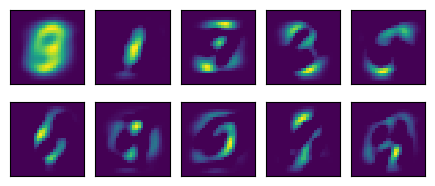

[[-4.3696041e+00 -7.3027568e+00  3.7173772e+00  2.4614029e+00
   3.1738219e+00  3.9043636e+00  2.4595821e+00 -2.0241132e+00
   5.0065866e+00  6.9458084e-04 -1.4217702e-01]]


In [15]:
display_dictionary(results_dict["loading"][0], grid_shape = [2,5])
print(results_dict["loading"][1])

In [5]:
# BCD implementation

from src.SDL_BCD import SDL_BCD

r = 10
W0_H, W0_W, H0 = find_initial(X_train.T, y_train0.reshape(1, -1), r = r, generate="random")

SDL_BCD_class = SDL_BCD(X=[X_train.T, y_train0.reshape(1, -1)],  # data, label
                                    X_test=[X_test.T, y_test0.reshape(1, -1)],
                                    n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                    ini_loading=W0_W,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                    ini_code = H0,
                                    xi=0.9,  # weight on label reconstruction error
                                    L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                    L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                    nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                                    full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

results_dict_new = SDL_BCD_class.fit(iter=1000, subsample_size=None,
                                        beta = 0,
                                        option = "filter",
                                        search_radius_const=0.1,
                                        update_nuance_param=False,
                                        if_compute_recons_error=True, if_validate=True)

results_dict_new.update({'method': 'SMF-filt'})
results_dict_new.update({'Accuracy': round(results_dict.get('Accuracy'),3)})
results_dict_new.update({'F_score': round(results_dict.get('F_score'),3)})

/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


initial loading beta [[-3.15772408  0.58293123  0.23362491 -0.06454215 -0.31636899  0.31214316
  -0.36327866 -0.01807874  0.14596458 -0.45946479 -0.07278079]]


  0%|                                          | 1/1000 [00:00<10:48,  1.54it/s]

--- Training --- [threshold, AUC] =  [0.129, 0.906]
--- Iteration 0: Training loss --- [Data, Label, Total] = [641224.673830.3, 1785.842672.3, 578888.049119.3]


  1%|▍                                        | 10/1000 [00:04<06:30,  2.54it/s]

--- Training --- [threshold, AUC] =  [0.134, 0.973]
--- Iteration 10: Training loss --- [Data, Label, Total] = [573612.765073.3, 853.513089.3, 517105.001655.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.134, 0.973]


  1%|▍                                        | 11/1000 [00:05<11:35,  1.42it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.153, 0.979, 0.944, 0.788]


  2%|▊                                        | 20/1000 [00:07<04:16,  3.82it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.974]
--- Iteration 20: Training loss --- [Data, Label, Total] = [571274.751639.3, 858.494552.3, 515005.771027.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.974]


  2%|▊                                        | 21/1000 [00:09<09:57,  1.64it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.979, 0.958, 0.832]


  3%|█▏                                       | 30/1000 [00:12<05:16,  3.07it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.974]
--- Iteration 30: Training loss --- [Data, Label, Total] = [569670.444111.3, 859.755429.3, 513563.155129.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.974]


  3%|█▎                                       | 31/1000 [00:14<10:31,  1.53it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.172, 0.979, 0.959, 0.833]


  4%|█▋                                       | 40/1000 [00:15<03:49,  4.18it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.974]
--- Iteration 40: Training loss --- [Data, Label, Total] = [568224.056694.3, 860.439073.3, 512262.090098.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.974]


  4%|█▋                                       | 42/1000 [00:17<07:19,  2.18it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.172, 0.979, 0.958, 0.831]


  5%|██                                       | 50/1000 [00:19<03:54,  4.06it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.974]
--- Iteration 50: Training loss --- [Data, Label, Total] = [566872.394886.3, 861.216409.3, 511046.371806.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.974]


  5%|██                                       | 51/1000 [00:20<09:14,  1.71it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.171, 0.979, 0.959, 0.833]


  6%|██▍                                      | 60/1000 [00:22<03:50,  4.08it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.974]
--- Iteration 60: Training loss --- [Data, Label, Total] = [565589.731209.3, 862.044575.3, 509892.802662.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.974]


  6%|██▌                                      | 61/1000 [00:24<09:22,  1.67it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.157, 0.979, 0.959, 0.833]


  7%|██▊                                      | 70/1000 [00:26<03:42,  4.17it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.974]
--- Iteration 70: Training loss --- [Data, Label, Total] = [564361.086558.3, 862.889821.3, 508787.867723.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.974]


  7%|██▉                                      | 71/1000 [00:27<08:37,  1.79it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.17, 0.979, 0.959, 0.833]


  8%|███▎                                     | 80/1000 [00:30<04:53,  3.13it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.974]
--- Iteration 80: Training loss --- [Data, Label, Total] = [563176.473855.3, 863.730879.3, 507722.557349.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.974]


  8%|███▎                                     | 81/1000 [00:31<09:29,  1.61it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.17, 0.979, 0.959, 0.833]


  9%|███▋                                     | 90/1000 [00:33<04:06,  3.70it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.974]
--- Iteration 90: Training loss --- [Data, Label, Total] = [562028.919257.3, 864.570962.3, 506690.598293.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.974]


  9%|███▋                                     | 91/1000 [00:35<08:53,  1.70it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.17, 0.979, 0.959, 0.833]


 10%|████                                    | 100/1000 [00:37<03:32,  4.24it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.974]
--- Iteration 100: Training loss --- [Data, Label, Total] = [560913.188018.3, 865.400401.3, 505687.269617.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.974]


 10%|████                                    | 101/1000 [00:38<08:10,  1.83it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.169, 0.979, 0.959, 0.833]


 11%|████▍                                   | 110/1000 [00:40<03:33,  4.17it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 110: Training loss --- [Data, Label, Total] = [559825.362137.3, 866.217328.3, 504709.043251.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 11%|████▍                                   | 111/1000 [00:41<08:16,  1.79it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.169, 0.979, 0.959, 0.833]


 12%|████▊                                   | 120/1000 [00:44<03:46,  3.88it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 120: Training loss --- [Data, Label, Total] = [558762.279940.3, 867.023682.3, 503753.075628.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 12%|████▊                                   | 121/1000 [00:45<08:19,  1.76it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.168, 0.979, 0.959, 0.833]


 13%|█████▏                                  | 130/1000 [00:47<03:53,  3.73it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 130: Training loss --- [Data, Label, Total] = [557721.404064.3, 867.807704.3, 502817.071362.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 13%|█████▏                                  | 131/1000 [00:48<08:26,  1.72it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.168, 0.979, 0.959, 0.833]


 14%|█████▌                                  | 140/1000 [00:51<05:26,  2.63it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 140: Training loss --- [Data, Label, Total] = [556700.635983.3, 868.580169.3, 501899.152554.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 14%|█████▋                                  | 141/1000 [00:53<09:37,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.168, 0.979, 0.959, 0.833]


 15%|██████                                  | 150/1000 [00:55<03:55,  3.61it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.974]
--- Iteration 150: Training loss --- [Data, Label, Total] = [555698.218474.3, 869.337708.3, 500997.734334.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.974]


 15%|██████                                  | 151/1000 [00:57<09:08,  1.55it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.167, 0.979, 0.959, 0.833]


 16%|██████▍                                 | 160/1000 [00:59<04:09,  3.37it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.974]
--- Iteration 160: Training loss --- [Data, Label, Total] = [554712.662444.3, 870.072307.3, 500111.468507.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.974]


 16%|██████▍                                 | 162/1000 [01:01<06:48,  2.05it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.167, 0.979, 0.959, 0.833]


 17%|██████▊                                 | 170/1000 [01:03<04:44,  2.92it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.974]
--- Iteration 170: Training loss --- [Data, Label, Total] = [553742.688553.3, 870.764162.3, 499239.183860.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.974]


 17%|██████▊                                 | 171/1000 [01:05<10:43,  1.29it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.167, 0.979, 0.959, 0.833]


 18%|███████▏                                | 180/1000 [01:07<03:37,  3.76it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.974]
--- Iteration 180: Training loss --- [Data, Label, Total] = [552787.179889.3, 871.517217.3, 498379.979117.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.974]


 18%|███████▏                                | 181/1000 [01:09<08:16,  1.65it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.166, 0.979, 0.959, 0.833]


 19%|███████▌                                | 190/1000 [01:11<03:16,  4.12it/s]

--- Training --- [threshold, AUC] =  [0.172, 0.974]
--- Iteration 190: Training loss --- [Data, Label, Total] = [551845.158596.3, 872.240838.3, 497532.883575.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.172, 0.974]


 19%|███████▋                                | 191/1000 [01:12<07:51,  1.72it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.166, 0.979, 0.959, 0.833]


 20%|████████                                | 200/1000 [01:15<04:34,  2.91it/s]

--- Training --- [threshold, AUC] =  [0.172, 0.974]
--- Iteration 200: Training loss --- [Data, Label, Total] = [550915.793034.3, 872.932051.3, 496697.145782.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.172, 0.974]


 20%|████████                                | 201/1000 [01:17<10:08,  1.31it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.166, 0.979, 0.959, 0.833]


 21%|████████▍                               | 210/1000 [01:20<03:43,  3.53it/s]

--- Training --- [threshold, AUC] =  [0.172, 0.974]
--- Iteration 210: Training loss --- [Data, Label, Total] = [549998.271384.3, 873.564953.3, 495872.009198.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.172, 0.974]


 21%|████████▍                               | 211/1000 [01:21<08:02,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.166, 0.979, 0.959, 0.833]


 22%|████████▊                               | 220/1000 [01:24<03:26,  3.78it/s]

--- Training --- [threshold, AUC] =  [0.172, 0.974]
--- Iteration 220: Training loss --- [Data, Label, Total] = [549091.955617.3, 874.219237.3, 495056.979293.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.172, 0.974]


 22%|████████▊                               | 221/1000 [01:25<07:52,  1.65it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.165, 0.979, 0.958, 0.832]


 23%|█████████▏                              | 230/1000 [01:27<03:15,  3.95it/s]

--- Training --- [threshold, AUC] =  [0.171, 0.974]
--- Iteration 230: Training loss --- [Data, Label, Total] = [548196.282003.3, 874.856373.3, 494251.510176.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.171, 0.974]


 23%|█████████▏                              | 231/1000 [01:29<07:48,  1.64it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.165, 0.979, 0.958, 0.832]


 24%|█████████▌                              | 240/1000 [01:31<03:12,  3.94it/s]

--- Training --- [threshold, AUC] =  [0.171, 0.974]
--- Iteration 240: Training loss --- [Data, Label, Total] = [547310.555172.3, 875.486672.3, 493454.986327.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.171, 0.974]


 24%|█████████▋                              | 241/1000 [01:32<07:44,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.165, 0.979, 0.958, 0.832]


 25%|██████████                              | 250/1000 [01:35<03:46,  3.32it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 250: Training loss --- [Data, Label, Total] = [546434.419165.3, 876.099655.3, 492667.076903.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 25%|██████████                              | 251/1000 [01:37<08:07,  1.54it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.165, 0.979, 0.958, 0.83]


 26%|██████████▍                             | 260/1000 [01:39<03:21,  3.67it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 260: Training loss --- [Data, Label, Total] = [545567.363287.3, 876.698756.3, 491887.325714.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 26%|██████████▍                             | 261/1000 [01:41<07:38,  1.61it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.164, 0.979, 0.958, 0.83]


 27%|██████████▊                             | 270/1000 [01:43<02:49,  4.32it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 270: Training loss --- [Data, Label, Total] = [544708.997249.3, 877.272718.3, 491115.370241.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 27%|██████████▊                             | 271/1000 [01:44<07:07,  1.71it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.164, 0.979, 0.958, 0.83]


 28%|███████████▏                            | 280/1000 [01:46<02:49,  4.26it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 280: Training loss --- [Data, Label, Total] = [543858.929034.3, 877.851687.3, 490350.887818.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 28%|███████████▏                            | 281/1000 [01:47<06:58,  1.72it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.164, 0.979, 0.958, 0.832]


 29%|███████████▌                            | 290/1000 [01:50<02:55,  4.06it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 290: Training loss --- [Data, Label, Total] = [543016.836465.3, 878.420142.3, 489593.572960.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 29%|███████████▋                            | 291/1000 [01:51<07:10,  1.65it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.164, 0.979, 0.958, 0.832]


 30%|████████████                            | 300/1000 [01:53<02:35,  4.50it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 300: Training loss --- [Data, Label, Total] = [542182.383569.3, 878.967015.3, 488843.112227.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 30%|████████████                            | 301/1000 [01:54<06:46,  1.72it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.183, 0.979, 0.958, 0.832]


 31%|████████████▍                           | 310/1000 [01:56<02:50,  4.04it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 310: Training loss --- [Data, Label, Total] = [541355.273441.3, 879.506267.3, 488099.252365.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 31%|████████████▍                           | 311/1000 [01:58<07:23,  1.55it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.183, 0.979, 0.958, 0.828]


 32%|████████████▊                           | 320/1000 [02:00<02:55,  3.87it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.974]
--- Iteration 320: Training loss --- [Data, Label, Total] = [540535.245396.3, 880.030700.3, 487361.751557.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.17, 0.974]


 32%|████████████▊                           | 321/1000 [02:02<07:00,  1.62it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.183, 0.979, 0.958, 0.828]


 33%|█████████████▏                          | 330/1000 [02:04<03:10,  3.52it/s]

--- Training --- [threshold, AUC] =  [0.169, 0.974]
--- Iteration 330: Training loss --- [Data, Label, Total] = [539722.045643.3, 880.536712.3, 486630.377790.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.169, 0.974]


 33%|█████████████▏                          | 331/1000 [02:05<06:57,  1.60it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.183, 0.979, 0.958, 0.828]


 34%|█████████████▌                          | 340/1000 [02:07<02:32,  4.32it/s]

--- Training --- [threshold, AUC] =  [0.165, 0.974]
--- Iteration 340: Training loss --- [Data, Label, Total] = [538915.446656.3, 881.047132.3, 485904.949122.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.165, 0.974]


 34%|█████████████▋                          | 341/1000 [02:09<06:20,  1.73it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.183, 0.979, 0.958, 0.828]


 35%|██████████████                          | 350/1000 [02:11<02:27,  4.42it/s]

--- Training --- [threshold, AUC] =  [0.165, 0.974]
--- Iteration 350: Training loss --- [Data, Label, Total] = [538115.208493.3, 881.541885.3, 485185.229529.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.165, 0.974]


 35%|██████████████                          | 351/1000 [02:12<06:14,  1.73it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 36%|██████████████▍                         | 360/1000 [02:14<02:41,  3.97it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 360: Training loss --- [Data, Label, Total] = [537321.140115.3, 882.019086.3, 484471.045189.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 36%|██████████████▍                         | 361/1000 [02:16<06:47,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 37%|██████████████▊                         | 370/1000 [02:18<02:36,  4.03it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 370: Training loss --- [Data, Label, Total] = [536533.071619.3, 882.463095.3, 483762.227552.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 37%|██████████████▊                         | 371/1000 [02:19<06:25,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 38%|███████████████▏                        | 380/1000 [02:21<02:21,  4.39it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 380: Training loss --- [Data, Label, Total] = [535750.767520.3, 882.954265.3, 483058.645033.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 38%|███████████████▎                        | 382/1000 [02:23<04:47,  2.15it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 39%|███████████████▌                        | 390/1000 [02:25<02:28,  4.10it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 390: Training loss --- [Data, Label, Total] = [534974.119109.3, 883.405361.3, 482360.112559.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 39%|███████████████▋                        | 391/1000 [02:26<05:53,  1.72it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 40%|████████████████                        | 400/1000 [02:28<02:20,  4.28it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 400: Training loss --- [Data, Label, Total] = [534202.970831.3, 883.846834.3, 481666.520583.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 40%|████████████████                        | 402/1000 [02:30<04:45,  2.09it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 41%|████████████████▍                       | 410/1000 [02:31<02:17,  4.31it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 410: Training loss --- [Data, Label, Total] = [533437.138688.3, 884.278363.3, 480977.703182.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 41%|████████████████▍                       | 411/1000 [02:33<05:38,  1.74it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 42%|████████████████▊                       | 420/1000 [02:35<02:12,  4.38it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 420: Training loss --- [Data, Label, Total] = [532676.496534.3, 884.701176.3, 480293.548057.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 42%|████████████████▊                       | 421/1000 [02:36<05:35,  1.73it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.184, 0.979, 0.958, 0.828]


 43%|█████████████████▏                      | 430/1000 [02:38<02:05,  4.54it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 430: Training loss --- [Data, Label, Total] = [531920.914964.3, 885.115548.3, 479613.939015.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 43%|█████████████████▎                      | 432/1000 [02:39<04:16,  2.22it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 44%|█████████████████▌                      | 440/1000 [02:41<02:05,  4.45it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 440: Training loss --- [Data, Label, Total] = [531170.270995.3, 885.521059.3, 478938.764954.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 44%|█████████████████▋                      | 442/1000 [02:43<04:09,  2.24it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 45%|██████████████████                      | 450/1000 [02:45<02:11,  4.17it/s]

--- Training --- [threshold, AUC] =  [0.167, 0.974]
--- Iteration 450: Training loss --- [Data, Label, Total] = [530424.453370.3, 885.927004.3, 478267.935036.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.167, 0.974]


 45%|██████████████████                      | 451/1000 [02:46<05:12,  1.76it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 46%|██████████████████▍                     | 460/1000 [02:48<01:59,  4.50it/s]

--- Training --- [threshold, AUC] =  [0.167, 0.974]
--- Iteration 460: Training loss --- [Data, Label, Total] = [529683.350556.3, 886.305653.3, 477601.321154.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.167, 0.974]


 46%|██████████████████▍                     | 461/1000 [02:49<05:04,  1.77it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 47%|██████████████████▊                     | 470/1000 [02:51<02:04,  4.27it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 470: Training loss --- [Data, Label, Total] = [528946.853239.3, 886.684479.3, 476938.852394.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 47%|██████████████████▊                     | 471/1000 [02:52<04:53,  1.80it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 48%|███████████████████▏                    | 480/1000 [02:54<01:58,  4.37it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 480: Training loss --- [Data, Label, Total] = [528214.873338.3, 887.042540.3, 476280.428544.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 48%|███████████████████▏                    | 481/1000 [02:56<04:46,  1.81it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 49%|███████████████████▌                    | 490/1000 [02:58<01:52,  4.52it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 490: Training loss --- [Data, Label, Total] = [527487.309771.3, 887.416141.3, 475625.994934.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 49%|███████████████████▋                    | 491/1000 [02:59<04:42,  1.80it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 50%|████████████████████                    | 500/1000 [03:01<01:56,  4.28it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 500: Training loss --- [Data, Label, Total] = [526764.075134.3, 887.769434.3, 474975.437054.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 50%|████████████████████                    | 501/1000 [03:02<05:00,  1.66it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 51%|████████████████████▍                   | 510/1000 [03:05<02:52,  2.83it/s]

--- Training --- [threshold, AUC] =  [0.166, 0.974]
--- Iteration 510: Training loss --- [Data, Label, Total] = [526045.097135.3, 888.115100.3, 474328.702521.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.166, 0.974]


 51%|████████████████████▍                   | 511/1000 [03:08<08:11,  1.00s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.958, 0.828]


 52%|████████████████████▊                   | 520/1000 [03:11<03:25,  2.34it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 520: Training loss --- [Data, Label, Total] = [525330.287925.3, 888.485881.3, 473685.745013.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 52%|████████████████████▊                   | 521/1000 [03:13<08:20,  1.04s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.953, 0.815]


 53%|█████████████████████▏                  | 530/1000 [03:18<03:00,  2.61it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 530: Training loss --- [Data, Label, Total] = [524619.532083.3, 888.781356.3, 473046.360230.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 53%|█████████████████████▏                  | 531/1000 [03:19<05:25,  1.44it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.979, 0.953, 0.815]


 54%|█████████████████████▌                  | 540/1000 [03:21<01:54,  4.03it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 540: Training loss --- [Data, Label, Total] = [523912.776513.3, 889.105964.3, 472410.604826.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 54%|█████████████████████▋                  | 541/1000 [03:23<04:34,  1.67it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.953, 0.815]


 55%|██████████████████████                  | 550/1000 [03:25<01:49,  4.12it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 550: Training loss --- [Data, Label, Total] = [523209.951024.3, 889.412460.3, 471778.368382.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 55%|██████████████████████                  | 552/1000 [03:26<03:29,  2.14it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.953, 0.815]


 56%|██████████████████████▍                 | 560/1000 [03:28<02:03,  3.56it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 560: Training loss --- [Data, Label, Total] = [522511.004187.3, 889.720012.3, 471149.623781.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 56%|██████████████████████▍                 | 561/1000 [03:30<04:36,  1.59it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.953, 0.815]


 57%|██████████████████████▊                 | 570/1000 [03:32<01:49,  3.93it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 570: Training loss --- [Data, Label, Total] = [521815.860749.3, 890.017991.3, 470524.292665.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 57%|██████████████████████▊                 | 571/1000 [03:33<04:20,  1.64it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.953, 0.815]


 58%|███████████████████████▏                | 580/1000 [03:35<01:40,  4.16it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 580: Training loss --- [Data, Label, Total] = [521124.458354.3, 890.308900.3, 469902.321418.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 58%|███████████████████████▏                | 581/1000 [03:37<04:08,  1.69it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.953, 0.815]


 59%|███████████████████████▌                | 590/1000 [03:39<01:54,  3.58it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 590: Training loss --- [Data, Label, Total] = [520436.736829.3, 890.587288.3, 469283.650435.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 59%|███████████████████████▋                | 591/1000 [03:40<04:08,  1.64it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.952, 0.813]


 60%|████████████████████████                | 600/1000 [03:42<01:34,  4.25it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 600: Training loss --- [Data, Label, Total] = [519752.643297.3, 890.868168.3, 468668.247136.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 60%|████████████████████████                | 601/1000 [03:44<03:50,  1.73it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.952, 0.813]


 61%|████████████████████████▍               | 610/1000 [03:46<01:34,  4.14it/s]

--- Training --- [threshold, AUC] =  [0.152, 0.974]
--- Iteration 610: Training loss --- [Data, Label, Total] = [519072.122023.3, 891.137871.3, 468056.047691.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.152, 0.974]


 61%|████████████████████████▍               | 611/1000 [03:47<03:50,  1.69it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.952, 0.813]


 62%|████████████████████████▊               | 620/1000 [03:49<01:27,  4.34it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 620: Training loss --- [Data, Label, Total] = [518395.118994.3, 891.400366.3, 467447.007461.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 62%|████████████████████████▊               | 621/1000 [03:51<03:41,  1.71it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 63%|█████████████████████████▏              | 630/1000 [03:53<01:27,  4.23it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 630: Training loss --- [Data, Label, Total] = [517721.583343.3, 891.656692.3, 466841.081701.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 63%|█████████████████████████▏              | 631/1000 [03:54<03:42,  1.66it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 64%|█████████████████████████▌              | 640/1000 [03:56<01:28,  4.08it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 640: Training loss --- [Data, Label, Total] = [517051.465562.3, 891.906055.3, 466238.225061.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 64%|█████████████████████████▋              | 641/1000 [03:57<03:32,  1.69it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 65%|██████████████████████████              | 650/1000 [04:00<01:25,  4.08it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 650: Training loss --- [Data, Label, Total] = [516384.711529.3, 892.149094.3, 465638.389471.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 65%|██████████████████████████              | 651/1000 [04:01<03:30,  1.66it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 66%|██████████████████████████▍             | 660/1000 [04:03<01:21,  4.17it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 660: Training loss --- [Data, Label, Total] = [515721.311209.3, 892.378511.3, 465041.558599.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 66%|██████████████████████████▍             | 662/1000 [04:05<02:44,  2.05it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 67%|██████████████████████████▊             | 670/1000 [04:07<01:22,  4.00it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 670: Training loss --- [Data, Label, Total] = [515061.159092.3, 892.616611.3, 464447.659794.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 67%|██████████████████████████▊             | 671/1000 [04:08<03:17,  1.66it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 68%|███████████████████████████▏            | 680/1000 [04:10<01:21,  3.94it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 680: Training loss --- [Data, Label, Total] = [514404.292044.3, 892.839608.3, 463856.702448.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 68%|███████████████████████████▎            | 682/1000 [04:12<02:33,  2.08it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 69%|███████████████████████████▌            | 690/1000 [04:14<01:17,  4.01it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.974]
--- Iteration 690: Training loss --- [Data, Label, Total] = [513750.616580.3, 893.056901.3, 463268.611822.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.164, 0.974]


 69%|███████████████████████████▋            | 691/1000 [04:15<03:07,  1.64it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 70%|████████████████████████████            | 700/1000 [04:19<02:48,  1.78it/s]

--- Training --- [threshold, AUC] =  [0.163, 0.974]
--- Iteration 700: Training loss --- [Data, Label, Total] = [513100.116793.3, 893.268418.3, 462683.373532.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.163, 0.974]


 70%|████████████████████████████            | 701/1000 [04:20<04:31,  1.10it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 71%|████████████████████████████▍           | 710/1000 [04:24<02:09,  2.24it/s]

--- Training --- [threshold, AUC] =  [0.163, 0.974]
--- Iteration 710: Training loss --- [Data, Label, Total] = [512452.741669.3, 893.474106.3, 462100.941608.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.163, 0.974]


 71%|████████████████████████████▍           | 711/1000 [04:26<03:43,  1.30it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 72%|████████████████████████████▊           | 720/1000 [04:29<01:20,  3.46it/s]

--- Training --- [threshold, AUC] =  [0.163, 0.974]
--- Iteration 720: Training loss --- [Data, Label, Total] = [511808.461497.3, 893.672623.3, 461521.287970.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.163, 0.974]


 72%|████████████████████████████▊           | 721/1000 [04:30<03:31,  1.32it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.186, 0.979, 0.957, 0.827]


 73%|█████████████████████████████▏          | 730/1000 [04:33<01:17,  3.46it/s]

--- Training --- [threshold, AUC] =  [0.152, 0.974]
--- Iteration 730: Training loss --- [Data, Label, Total] = [511167.236116.3, 893.867306.3, 460944.379810.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.152, 0.974]


 73%|█████████████████████████████▏          | 731/1000 [04:34<02:51,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.813]


 74%|█████████████████████████████▌          | 740/1000 [04:36<01:00,  4.30it/s]

--- Training --- [threshold, AUC] =  [0.152, 0.974]
--- Iteration 740: Training loss --- [Data, Label, Total] = [510529.044316.3, 894.054434.3, 460370.194318.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.152, 0.974]


 74%|█████████████████████████████▋          | 741/1000 [04:38<02:34,  1.68it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.813]


 75%|██████████████████████████████          | 750/1000 [04:40<01:03,  3.96it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 750: Training loss --- [Data, Label, Total] = [509893.846681.3, 894.236388.3, 459798.698401.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 75%|██████████████████████████████          | 751/1000 [04:42<02:31,  1.65it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.813]


 76%|██████████████████████████████▍         | 760/1000 [04:44<01:00,  3.97it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 760: Training loss --- [Data, Label, Total] = [509261.618707.3, 894.416580.3, 459229.873417.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 76%|██████████████████████████████▍         | 761/1000 [04:45<02:27,  1.62it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.813]


 77%|██████████████████████████████▊         | 770/1000 [04:47<00:59,  3.87it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 770: Training loss --- [Data, Label, Total] = [508632.498595.3, 894.590073.3, 458663.838809.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 77%|██████████████████████████████▊         | 771/1000 [04:49<02:21,  1.62it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 78%|███████████████████████████████▏        | 780/1000 [04:52<01:05,  3.33it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 780: Training loss --- [Data, Label, Total] = [508006.099380.3, 894.750811.3, 458100.240253.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 78%|███████████████████████████████▏        | 781/1000 [04:53<02:21,  1.55it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 79%|███████████████████████████████▌        | 790/1000 [04:55<00:48,  4.30it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 790: Training loss --- [Data, Label, Total] = [507382.560561.3, 894.918528.3, 457539.223034.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 79%|███████████████████████████████▋        | 791/1000 [04:56<02:08,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 80%|████████████████████████████████        | 800/1000 [04:59<00:48,  4.09it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 800: Training loss --- [Data, Label, Total] = [506761.883770.3, 895.057932.3, 456980.753325.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 80%|████████████████████████████████        | 801/1000 [05:00<02:06,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 81%|████████████████████████████████▍       | 810/1000 [05:03<01:03,  3.01it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 810: Training loss --- [Data, Label, Total] = [506144.023078.3, 895.214788.3, 456424.835558.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 81%|████████████████████████████████▍       | 811/1000 [05:05<02:17,  1.38it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 82%|████████████████████████████████▊       | 820/1000 [05:07<00:45,  3.99it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 820: Training loss --- [Data, Label, Total] = [505528.943924.3, 895.357925.3, 455871.407456.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 82%|████████████████████████████████▊       | 821/1000 [05:08<01:49,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 83%|█████████████████████████████████▏      | 830/1000 [05:10<00:40,  4.25it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.974]
--- Iteration 830: Training loss --- [Data, Label, Total] = [504916.638702.3, 895.498076.3, 455320.472908.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.974]


 83%|█████████████████████████████████▏      | 831/1000 [05:12<01:52,  1.51it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.813]


 84%|█████████████████████████████████▌      | 840/1000 [05:14<00:49,  3.23it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 840: Training loss --- [Data, Label, Total] = [504307.091168.3, 895.632624.3, 454772.014675.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 84%|█████████████████████████████████▋      | 842/1000 [05:16<01:22,  1.92it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 85%|██████████████████████████████████      | 850/1000 [05:18<00:34,  4.35it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.974]
--- Iteration 850: Training loss --- [Data, Label, Total] = [503700.272156.3, 895.762513.3, 454226.007453.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.974]


 85%|██████████████████████████████████      | 851/1000 [05:19<01:30,  1.65it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.952, 0.812]


 86%|██████████████████████████████████▍     | 860/1000 [05:22<00:40,  3.44it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 860: Training loss --- [Data, Label, Total] = [503096.148055.3, 895.882688.3, 453682.415937.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 86%|██████████████████████████████████▍     | 861/1000 [05:23<01:33,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 87%|██████████████████████████████████▊     | 870/1000 [05:25<00:31,  4.07it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 870: Training loss --- [Data, Label, Total] = [502494.687180.3, 896.023899.3, 453141.242361.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 87%|██████████████████████████████████▊     | 871/1000 [05:27<01:19,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 88%|███████████████████████████████████▏    | 880/1000 [05:29<00:36,  3.33it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 880: Training loss --- [Data, Label, Total] = [501895.878403.3, 896.119761.3, 452602.410324.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 88%|███████████████████████████████████▏    | 881/1000 [05:31<01:32,  1.28it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 89%|███████████████████████████████████▌    | 890/1000 [05:33<00:27,  4.03it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 890: Training loss --- [Data, Label, Total] = [501299.704866.3, 896.226565.3, 452065.960944.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 89%|███████████████████████████████████▋    | 891/1000 [05:35<01:07,  1.61it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 90%|████████████████████████████████████    | 900/1000 [05:37<00:27,  3.60it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 900: Training loss --- [Data, Label, Total] = [500706.148821.3, 896.331398.3, 451531.865337.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 90%|████████████████████████████████████    | 901/1000 [05:39<01:06,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 91%|████████████████████████████████████▍   | 910/1000 [05:41<00:25,  3.56it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 910: Training loss --- [Data, Label, Total] = [500115.186302.3, 896.429681.3, 451000.097353.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 91%|████████████████████████████████████▍   | 911/1000 [05:43<00:54,  1.62it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 92%|████████████████████████████████████▊   | 920/1000 [05:45<00:21,  3.77it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 920: Training loss --- [Data, Label, Total] = [499526.800378.3, 896.526559.3, 450470.646899.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 92%|████████████████████████████████████▊   | 921/1000 [05:47<00:50,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 93%|█████████████████████████████████████▏  | 930/1000 [05:48<00:15,  4.43it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 930: Training loss --- [Data, Label, Total] = [498940.970894.3, 896.619021.3, 449943.492826.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 93%|█████████████████████████████████████▏  | 931/1000 [05:50<00:40,  1.69it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 94%|█████████████████████████████████████▌  | 940/1000 [05:52<00:14,  4.16it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 940: Training loss --- [Data, Label, Total] = [498357.679294.3, 896.706510.3, 449418.617874.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 94%|█████████████████████████████████████▋  | 941/1000 [05:53<00:38,  1.52it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 95%|██████████████████████████████████████  | 950/1000 [05:57<00:16,  2.96it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 950: Training loss --- [Data, Label, Total] = [497776.906237.3, 896.822536.3, 448896.038149.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 95%|██████████████████████████████████████  | 951/1000 [05:59<00:33,  1.46it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 96%|██████████████████████████████████████▍ | 960/1000 [06:01<00:10,  3.89it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 960: Training loss --- [Data, Label, Total] = [497198.627400.3, 896.883012.3, 448375.647672.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 96%|██████████████████████████████████████▍ | 961/1000 [06:02<00:25,  1.52it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 97%|██████████████████████████████████████▊ | 970/1000 [06:06<00:07,  3.79it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 970: Training loss --- [Data, Label, Total] = [496622.864894.3, 896.944917.3, 447857.523321.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 97%|██████████████████████████████████████▊ | 971/1000 [06:07<00:18,  1.60it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 98%|███████████████████████████████████████▏| 980/1000 [06:09<00:04,  4.24it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 980: Training loss --- [Data, Label, Total] = [496049.558757.3, 897.013640.3, 447341.616520.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 98%|███████████████████████████████████████▎| 982/1000 [06:11<00:08,  2.07it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


 99%|███████████████████████████████████████▌| 990/1000 [06:13<00:02,  3.74it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.974]
--- Iteration 990: Training loss --- [Data, Label, Total] = [495478.697620.3, 897.079702.3, 446827.907560.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


 99%|███████████████████████████████████████▋| 992/1000 [06:15<00:04,  1.98it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.979, 0.959, 0.833]


100%|███████████████████████████████████████| 1000/1000 [06:16<00:00,  2.65it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.974]


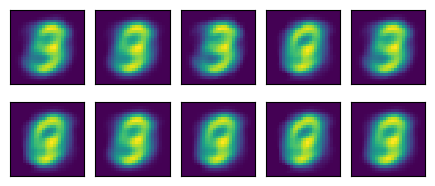

[[-3.3570708   7.66415218  3.1850433  11.5323818  -7.1350492   7.73385592
  -7.62731908  3.26396391 -3.77186316 -8.72549338 -0.66502378]]


In [7]:
import matplotlib.pyplot as plt
display_dictionary(results_dict_new["loading"][0], grid_shape = [2,5])
print(results_dict_new["loading"][1])